# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [2]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [3]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')

In [4]:
desc(air_reserve)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


(92378, 4)
air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object


In [5]:
desc(air_store_info)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


(829, 5)
air_store_id       object
air_genre_name     object
air_area_name      object
latitude          float64
longitude         float64
dtype: object


In [6]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [7]:
desc(air_visit_data)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


(252108, 3)
air_store_id            object
visit_date      datetime64[ns]
visitors                 int64
dtype: object


In [8]:
desc(date_info)

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


(517, 3)
calendar_date    object
day_of_week      object
holiday_flg       int64
dtype: object


In [9]:
desc(hpg_reserve)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


(2000320, 4)
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object


In [10]:
desc(hpg_store_info)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


(4690, 5)
hpg_store_id       object
hpg_genre_name     object
hpg_area_name      object
latitude          float64
longitude         float64
dtype: object


In [11]:
desc(sample_submission)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


(32019, 2)
id          object
visitors     int64
dtype: object


In [12]:
desc(store_id_relation)

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


(150, 2)
air_store_id    object
hpg_store_id    object
dtype: object


# Reservations vs. Visitors

Let's assume that `R`(reservations) is a subset of `V`(visitors), and call `V-R=WI` walk-ins. We want to know `WI/V` or, the percentage of visitors which are walk in, and how the distribution of reservations changes, by number of days beforehand. We call this timeseries `CWIP` or `cumulative walk-in percentage` and think of it in negative days(but normalize from day of first reservation to reverse the axis).

In [47]:
import itertools as it
from collections import Counter

In [89]:
def generate_freqs_of_days_before(input_df):
    all_days_ahead = []
    for visit_dt in input_df.visit_datetime.unique():
        all_days_ahead += [(pd.to_datetime(visit_dt)-pd.to_datetime(dt)).days for dt in input_df.loc[input_df['visit_datetime']==visit_dt]['reserve_datetime']]
    return dict(Counter(sorted(all_days_ahead, reverse=True)))

In [74]:
def generate_cdf_of_days_before(input_df):
    all_days_ahead = []
    for visit_dt in input_df.visit_datetime.unique():
        all_days_ahead += [(pd.to_datetime(visit_dt)-pd.to_datetime(dt)).days for dt in input_df.loc[input_df['visit_datetime']==visit_dt]['reserve_datetime']]
    val_freqs = dict(Counter(sorted(all_days_ahead, reverse=True)))
    cdf,current_total,total_days = [],0,sum(val_freqs.values())
    for i in range(max(val_freqs.keys())+1)[::-1]:
        current_total = current_total if i not in val_freqs.keys() else current_total + val_freqs[i]
        cdf.append((i,current_total/float(total_days)))
    return cdf

In [103]:
def generate_cdf_from_freqs(val_freqs):
    cdf, current_total, total_days = [], 0, sum(val_freqs.values())
    for i in range(max(val_freqs.keys())+1)[::-1]:
        current_total = current_total if i not in val_freqs.keys() else current_total + val_freqs[i]
        cdf.append((i,current_total/float(total_days)))
    return cdf

In [158]:
def draw_cdf_histo(cdf_pairs_list):
    days_out, probabilities = [], []

    for i in range(len(cdf_pairs_list)):
      days_out.append(cdf_pairs_list[i][0])
      probabilities.append(cdf_pairs_list[i][1])

    plt.figure(figsize=(16,4))
    plt.bar(days_out, probabilities, color='r', alpha=0.75)
    plt.show()

Here are ten arbitrary store's cdfs. If we join some metadata to this table, we could instead run through things clustered by that. 

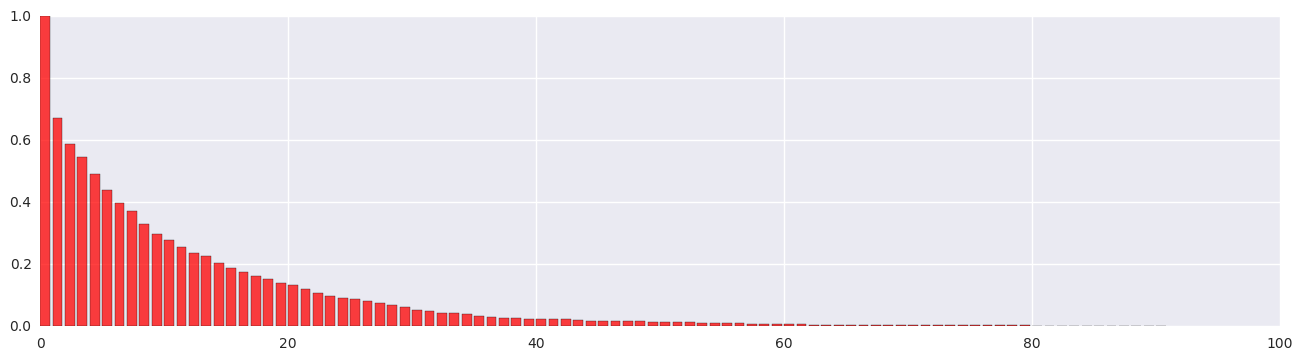

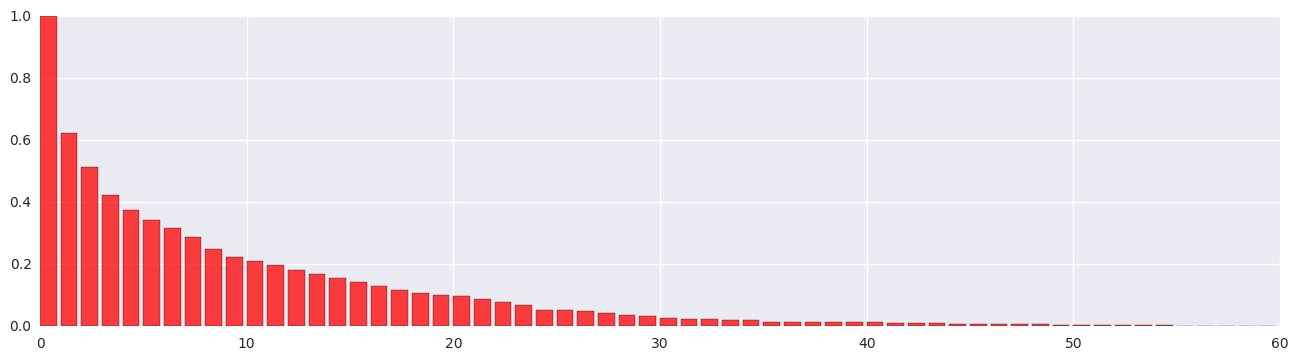

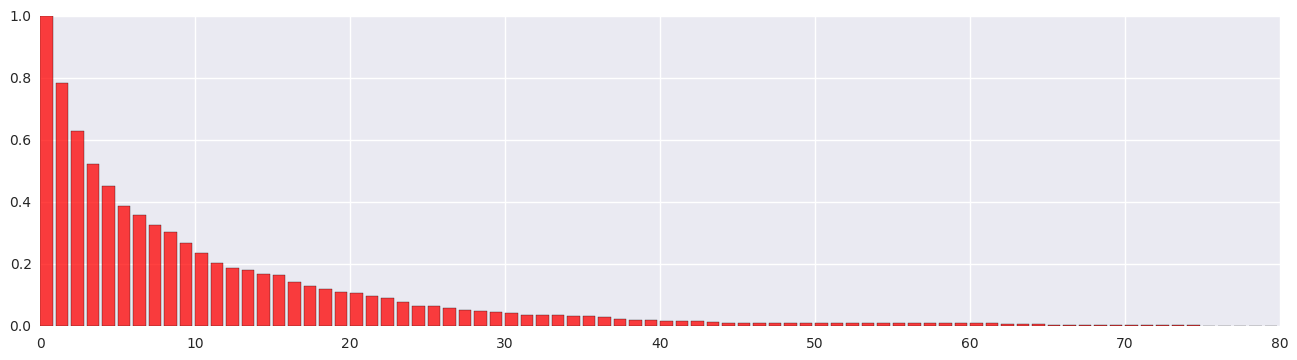

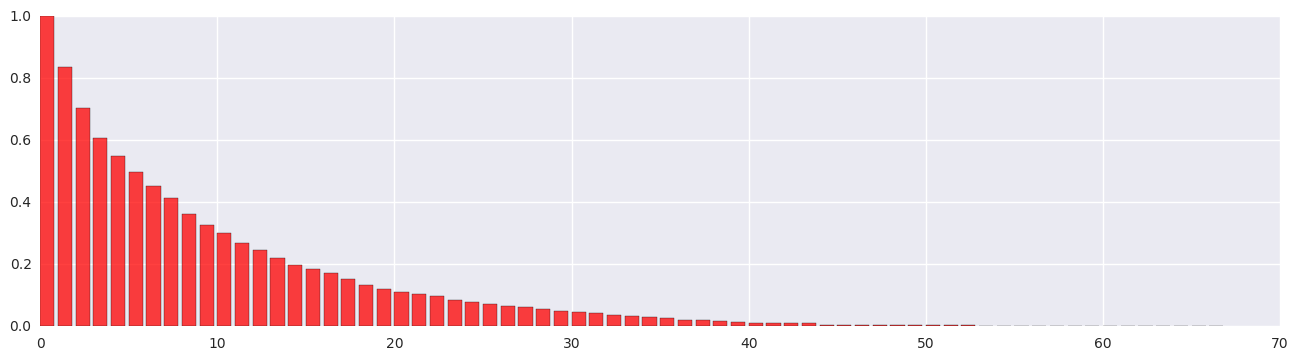

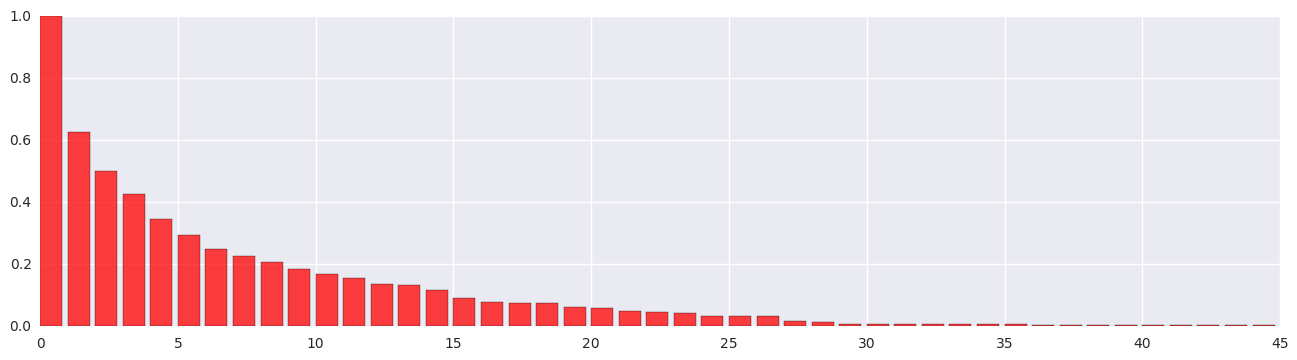

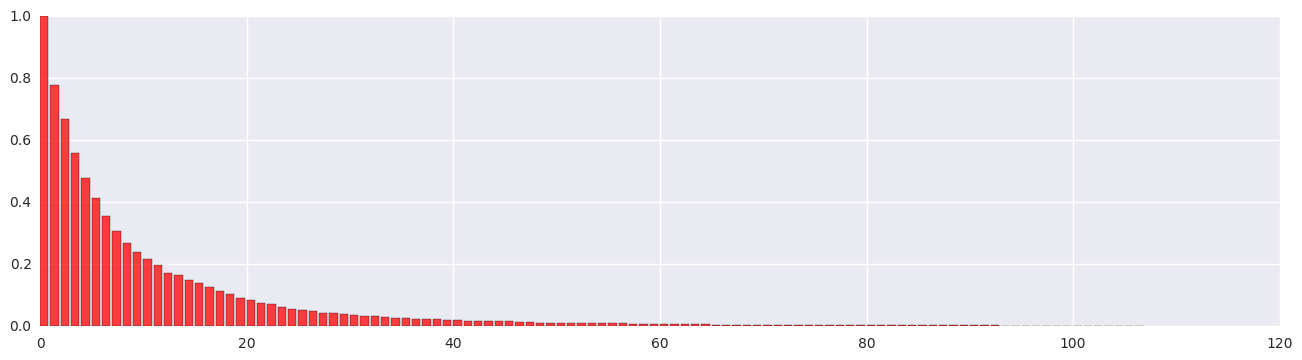

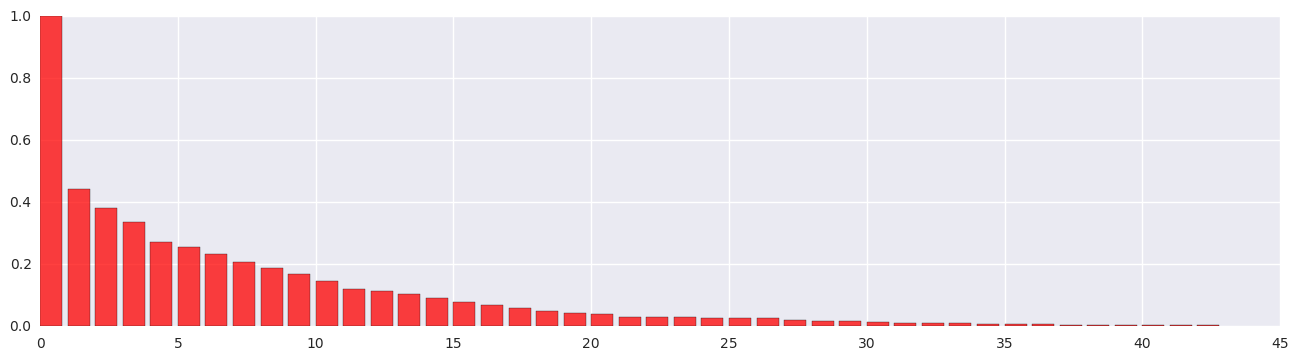

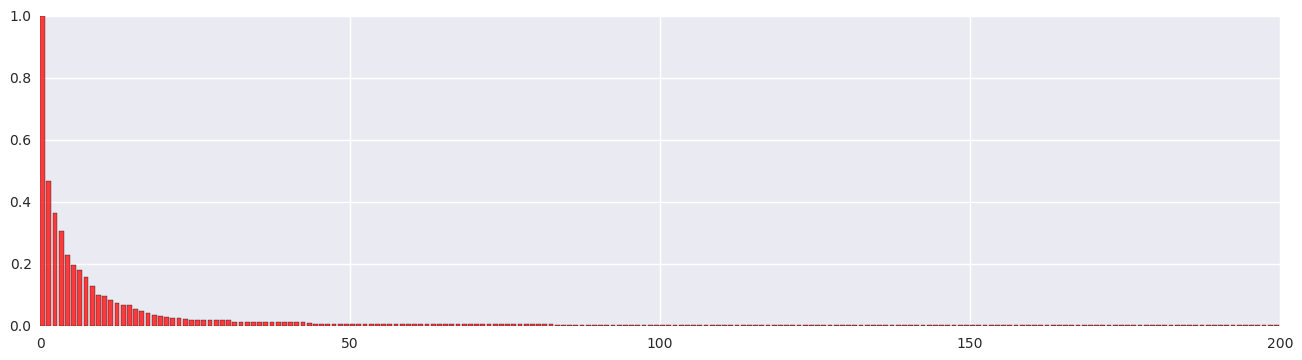

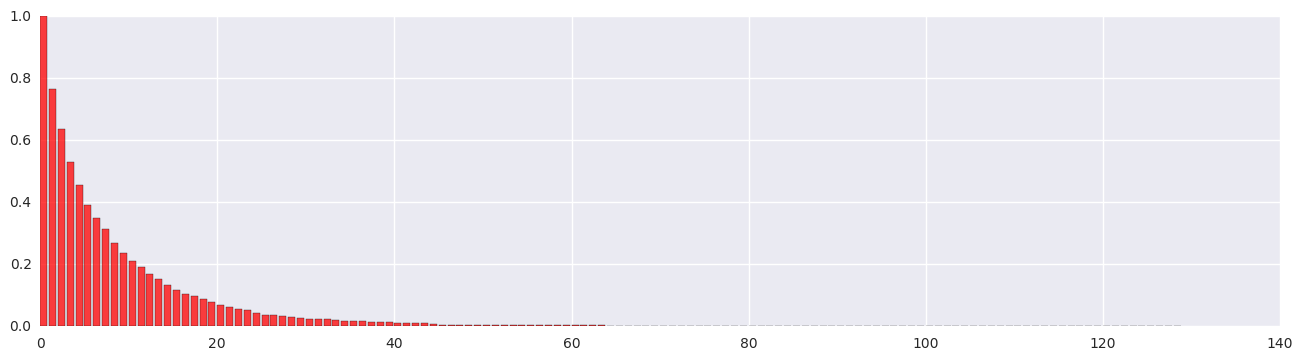

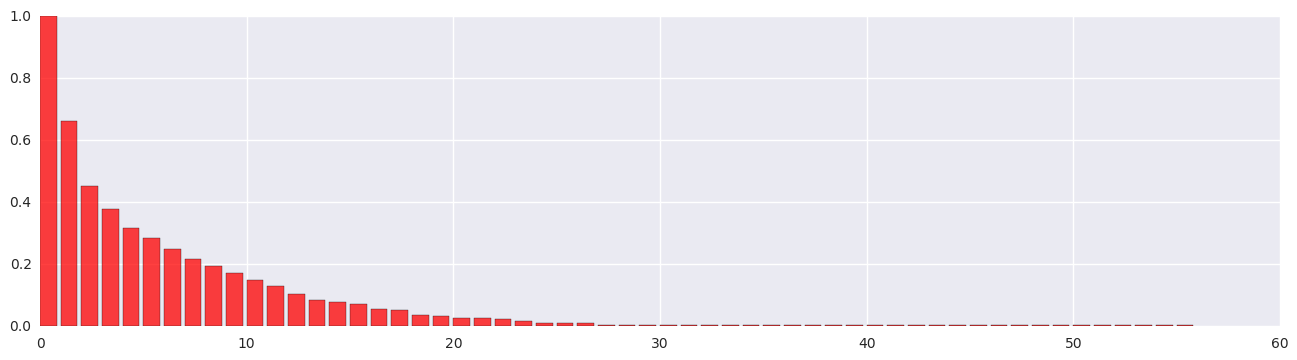

In [159]:
count = 0
for loc in air_reserve.air_store_id.unique():
    if count<10:
        draw_cdf_histo(generate_cdf_of_days_before(air_reserve.loc[air_reserve['air_store_id']==loc]))
    count+=1

Here I build the overall cdf, and then drop vals such that the cumulative prob `<1%`, to make the images more meaningful.

'This takes a while; if patient, change the conditional to True'

[(110, 0.010024031695858322), (109, 0.010099807313429604), (108, 0.010164757842776418), (107, 0.010240533460347702), (106, 0.010294658901470046), (105, 0.010327134166143455), (104, 0.010392084695490269), (103, 0.010402909783714737), (102, 0.01047868540128602), (101, 0.010511160665959427), (100, 0.010565286107081772), (99, 0.010630236636428586), (98, 0.010727662430448807), (97, 0.01081426313624456), (96, 0.010879213665591374), (95, 0.010976639459611595), (94, 0.01105241507718288), (93, 0.0111498408712031), (92, 0.011247266665223321), (91, 0.011290567018121197), (90, 0.011398817900365888), (89, 0.01147459351793717), (88, 0.011539544047283985), (87, 0.011626144753079737), (86, 0.011680270194202083), (85, 0.011766870899997835), (84, 0.011885946870466995), (83, 0.012015847929160623), (82, 0.012069973370282967), (81, 0.012134923899629783), (80, 0.012178224252527658), (79, 0.012362250752343632), (78, 0.012513801987486198), (77, 0.012600402693281951), (76, 0.012697828487302172), (75, 0.0127736

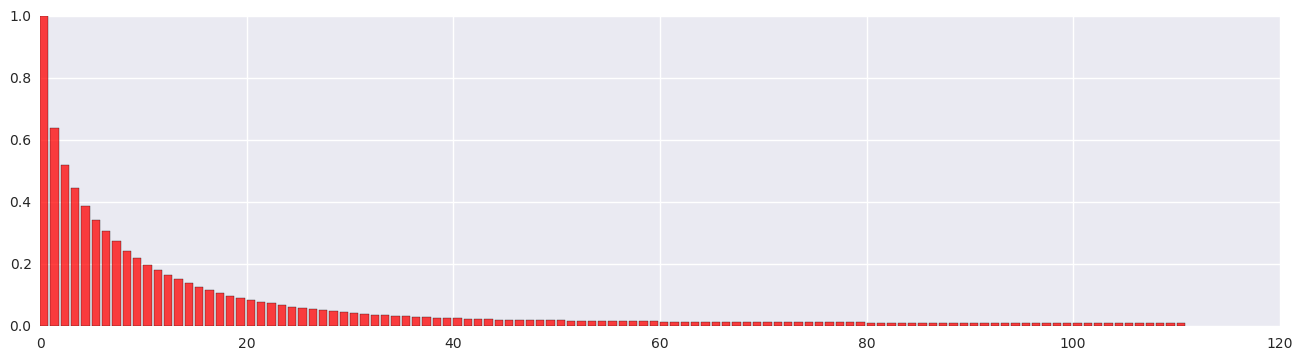

In [163]:
'''This takes a while; if patient, change the conditional to True'''
if False:
    total_freqs = {}
    for loc in air_reserve.air_store_id.unique():
        locs_freqs = generate_freqs_of_days_before(air_reserve.loc[air_reserve['air_store_id']==loc])
        for i in locs_freqs:
            total_freqs[i] = (locs_freqs[i] if i not in total_freqs else (total_freqs[i]+locs_freqs[i]))
sig_cdf_pairs = [p for p in generate_cdf_from_freqs(total_freqs) if p[1]>0.01]
print sig_cdf_pairs
draw_cdf_histo(sig_cdf_pairs)

### For HPG

'This takes a lonnnnng time; if super patient, change the conditional to True'

[(49, 0.010445317616240995), (48, 0.010991049989085353), (47, 0.01138397729753329), (46, 0.011886051080550098), (45, 0.012497271338135779), (44, 0.013130320890635233), (43, 0.013959834097358655), (42, 0.014985810958306046), (41, 0.015858982754857018), (40, 0.016895874263261296), (39, 0.017976424361493125), (38, 0.019297096703776467), (37, 0.02055228116131849), (36, 0.022058502510368914), (35, 0.023761187513643308), (34, 0.02550753110674525), (33, 0.02692643527614058), (32, 0.028847413228552717), (31, 0.031019428072473258), (30, 0.03369351669941061), (29, 0.036618642217856365), (28, 0.04002401222440515), (27, 0.04333115040384196), (26, 0.04679109364767518), (25, 0.05094957432874918), (24, 0.05472604234883213), (23, 0.06005239030779306), (22, 0.0657934948701157), (21, 0.0718947827985156), (20, 0.07803972931674306), (19, 0.08405370006548789), (18, 0.09111547697009387), (17, 0.10007640253219821), (16, 0.11021611001964636), (15, 0.12078148875791311), (14, 0.13284217419777342), (13, 0.146212

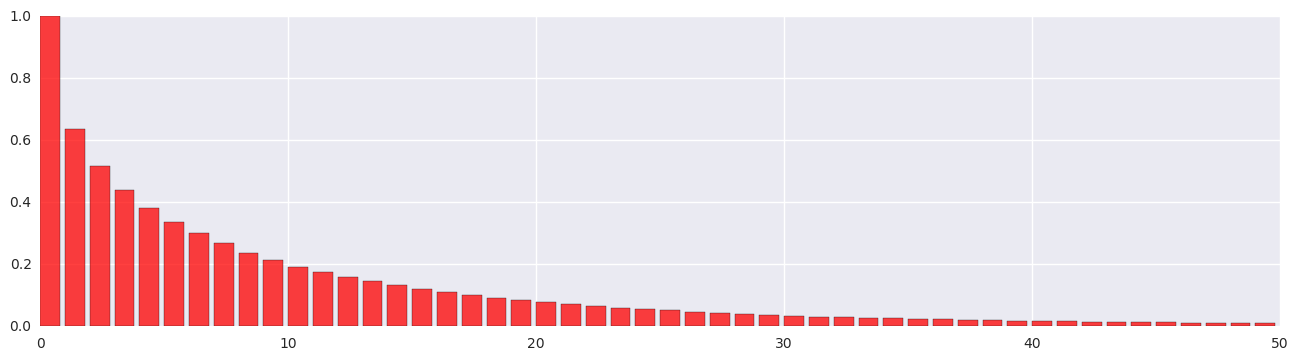

In [164]:
'''This takes a lonnnnng time; if super patient, change the conditional to True'''
if False:
    total_hpg_freqs,count = {},0
    for loc in hpg_reserve.hpg_store_id.unique():
        locs_freqs = generate_freqs_of_days_before(hpg_reserve.loc[hpg_reserve['hpg_store_id']==loc])
        for i in locs_freqs:
            total_hpg_freqs[i] = (locs_freqs[i] if i not in total_freqs else (total_freqs[i]+locs_freqs[i]))
sig_hpg_cdf_pairs = [p for p in generate_cdf_from_freqs(total_hpg_freqs) if p[1]>0.01]
print sig_hpg_cdf_pairs
draw_cdf_histo(sig_hpg_cdf_pairs)

## Combined CDF and corresponding plot

[(63, 0.010016413221882847), (62, 0.010217502364156132), (61, 0.0105490277068229), (60, 0.010706638115631691), (59, 0.0111033815584952), (58, 0.011358819117599105), (57, 0.011538168893140143), (56, 0.011858824552440788), (55, 0.012212089261839802), (54, 0.012489266187675954), (53, 0.012799052163610474), (52, 0.013271883390036848), (51, 0.013733844933097098), (50, 0.014282763943086339), (49, 0.014864292003173948), (48, 0.015396906488114), (47, 0.015782780247611386), (46, 0.01627735084077001), (45, 0.016880618267589863), (44, 0.01750562506114197), (43, 0.018326286155284296), (42, 0.01934260155001685), (41, 0.02020674137762367), (40, 0.021233926455722345), (39, 0.022304590267285512), (38, 0.023614387112903402), (37, 0.024853531016641485), (36, 0.026348112479483474), (35, 0.028038348242915685), (34, 0.02977206273981239), (33, 0.03117968673572539), (32, 0.03308731616648007), (31, 0.03524494831465559), (30, 0.0379025858976728), (29, 0.04081022619811085), (28, 0.04419613256665833), (27, 0.047

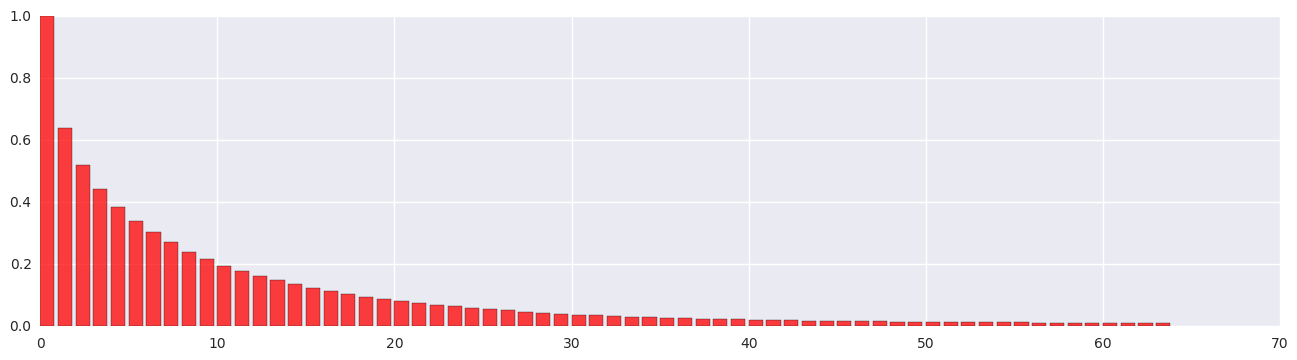

In [165]:
overall_sig_cdf_pairs = [p for p in generate_cdf_from_freqs(dict(Counter(total_hpg_freqs) + Counter(total_freqs))) if p[1]>0.01]
print overall_sig_cdf_pairs
draw_cdf_histo(overall_sig_cdf_pairs)

Here's the result in a df:

In [166]:
overall_reservations_percentages_df = pd.DataFrame(generate_cdf_from_freqs(dict(Counter(total_hpg_freqs) + Counter(total_freqs))))